# 고객 대출등급 예측 데이터셋
- multi-class 데이터셋
- 학습 데이터
    - https://drive.google.com/file/d/14IjwnpOHB7NBgEiujPErY3C5X5E6LAzi/view?usp=sharing
- 평가 데이터
    - https://drive.google.com/file/d/13B0Kstc31VQxxsu5nm6RhKlGTehdhrPD/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/data/"
SEED = 42

In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv(f"{DATA_PATH}loan_grade_train.csv")
test = pd.read_csv(f"{DATA_PATH}loan_grade_test.csv")

train.shape, test.shape

((19548, 10), (13033, 9))

In [4]:
train.head()

,ID,나이,연간소득,주택소유상태,근로기간,대출목적,대출금액,이자율,신용거래기간,target
0,train_0,26,33996,임대,10.0,투자,7000,8.00,2,0
1,train_1,34,84000,임대,3.0,개인사업,9000,5.79,10,0
2,train_2,22,24702,임대,NaN,교육,2000,13.23,4,2
3,train_3,24,69996,임대,3.0,부채통합,2500,12.53,3,1
4,train_4,26,58125,모기지론,10.0,투자,6000,10.25,2,1


- 0 클래스에 가까울수록 신용이 좋음

In [5]:
train["target"].value_counts(normalize=True)

,proportion
target,
0,0.330776
1,0.320749
2,0.198230
3,0.111316
4,0.029568
5,0.007418
6,0.001944


# 결측치 처리

In [6]:
train.isna().sum()

,0
ID,0
나이,0
연간소득,0
주택소유상태,0
근로기간,571
대출목적,0
대출금액,0
이자율,1874
신용거래기간,0
target,0


In [7]:
test.isna().sum()

,0
ID,0
나이,0
연간소득,0
주택소유상태,0
근로기간,324
대출목적,0
대출금액,0
이자율,1242
신용거래기간,0


In [8]:
period_mean, interest_mean = train["근로기간"].mean(), train["이자율"].mean()

train["근로기간"] = train["근로기간"].fillna(period_mean)
train["이자율"] = train["이자율"].fillna(interest_mean)

test["근로기간"] = test["근로기간"].fillna(period_mean)
test["이자율"] = test["이자율"].fillna(interest_mean)

train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

# 특성 선택

In [9]:
train_ft = train.iloc[:, 1:-1].copy()
test_ft = test.iloc[:, 1:].copy()

train_ft.shape, test_ft.shape

((19548, 8), (13033, 8))

# 피처인코딩

In [10]:
from sklearn.preprocessing import OneHotEncoder

cols = ["주택소유상태", "대출목적"]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(train_ft[cols])
train_ft[enc.get_feature_names_out()] = enc.transform(train_ft[cols]).toarray()
test_ft[enc.get_feature_names_out()] = enc.transform(test_ft[cols]).toarray()

train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)

In [11]:
train_ft.select_dtypes("object").columns

Index([], dtype='object')

In [12]:
train_ft.shape, test_ft.shape

((19548, 16), (13033, 16))

# 피처 스케일링

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

In [14]:
train_ft.head()

,나이,연간소득,근로기간,대출금액,이자율,신용거래기간,주택소유상태_기타,주택소유상태_모기지론,주택소유상태_소유,주택소유상태_임대,대출목적_개인사업,대출목적_교육,대출목적_부채통합,대출목적_의료,대출목적_주택개선,대출목적_투자
0,0.048387,0.014734,0.081301,0.188406,0.154584,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.112903,0.039297,0.024390,0.246377,0.022169,0.285714,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.016129,0.010169,0.039111,0.043478,0.467945,0.071429,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.032258,0.032418,0.024390,0.057971,0.426004,0.035714,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.048387,0.026587,0.081301,0.159420,0.289395,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 정답데이터 분리

In [15]:
target = train["target"]

# lgbm, xgboost, catboost, randomforest
- cv 점수 확인해보기
    - 평가지표는 f1-macro

In [16]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

models = [RandomForestClassifier, LGBMClassifier, XGBClassifier, CatBoostClassifier]
for model in models:
    model = model(random_state=SEED)
    scores = cross_val_score(model, train_ft, target, cv=cv, scoring="f1_macro", n_jobs=-1)
    print(scores.mean())

0.5593687124692288
0.7708288273544209
0.673557149156925
0.7607076734645635


# 군집분석(Clustering analysis)
- 각 데이터의 유사성을 측정하여 다수의 군집으로 나누고 군집 간의 서로 다른 특성을 확인하는 분석​
- 유사도가 높은 데이터끼리 그룹화
- 예측을 위한 모델링 보다는 EDA를 위해 많이 사용(정답 보장 X)


## K-means(K-평균 군집화)
- 거리 기반 군집화로 가장 일반적으로 사용되는 알고리즘
- K개의 랜덤한 중심점으로 시작하여 K개의 중심점을 이동하며 가까운 데이터들을 묶는 군집화 기법​
1. 랜덤하게 K개의 중심점을 지정
2. 각 중심점별로 가까운 데이터들을 그룹화
3. 각 그룹의 평균 지점으로 중심점 이동
4. 중심점 이동 시 그룹에 속한 데이터의 변경이 없을 때까지 2~3단계 반복




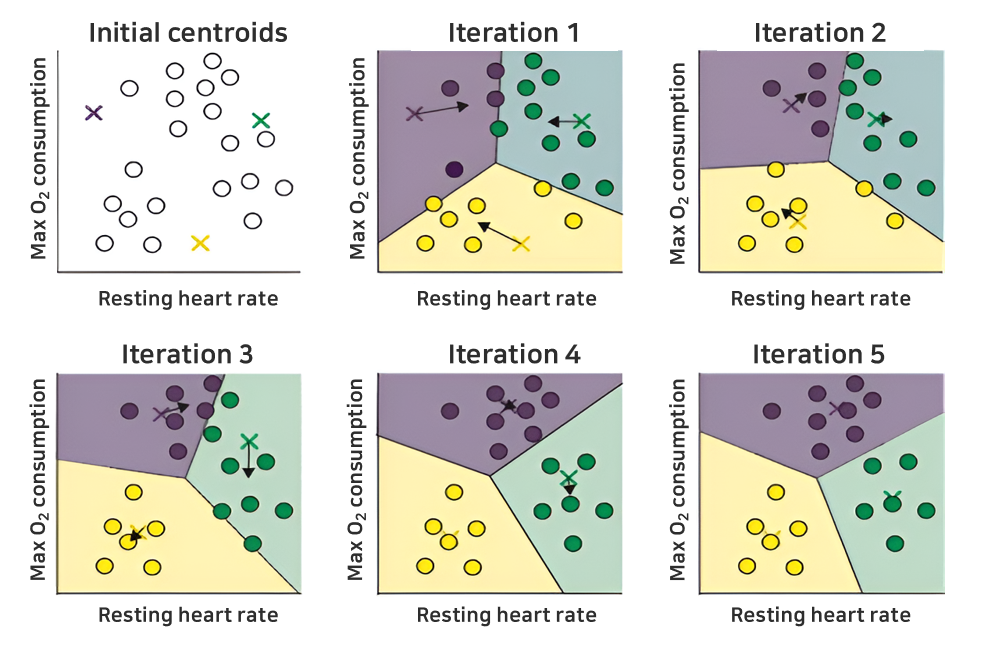

- 초기 중심에 민감하다.
    - 초기중심을 정해야하는 부분이 숙제!!
    - 랜덤하게 지정된 초기중심에 따라 결과가 많이 달라진다
- K-means++
    - 초기 중심점 선정의 어려움을 해결하기 위한 방법
        - 랜덤하게 1개의 데이터샘플을 중심점으로 선택
        - 해당 샘플과 가장 먼 샘플을 2번째 중심점으로 선택
        - 이 과정을 k 개가 될때까지 반복 후 군집화 진행한다.

- KMeans 클래스 주요 파라미터
    - random_state
        - 시드값
    - n_clusters
        - 군집수(K를 의미)
    - init
        - 초기 중심점 선정방법
        - 'k-means++'(기본값) , 'random'

In [22]:
target.nunique()

7

In [19]:
from sklearn.cluster import KMeans

cluster = KMeans(7, random_state=SEED)
cluster.fit(train_ft) # 학습

KMeans(n_clusters=7, random_state=42)

- 학습데이터의 각 샘플에 대한 군집번호

In [20]:
cluster.labels_

array([1, 2, 6, ..., 3, 1, 0], dtype=int32)

- 예측

In [21]:
cluster.predict(test_ft)

array([2, 6, 3, ..., 3, 6, 1], dtype=int32)

## 대표적인 군집화 성능 평가지표
- 군집화가 얼마나 잘되었는지 정량적으로 확인

### 사전에 정의된 그룹이 있는 경우
- 군집화 결과가 사전에 정의된 그룹을 얼마나 잘 설명하는지를 평가
- 예시로 정답클래스가 있는 경우 얼마나 각 클래스처럼 그룹화가 되어 있는가를 평가

- homogeneity_score 함수
    - 각 군집(예측값)이 동일한 클래스(실제값)로 구성되어 있는 정도(동질성)
        - 정밀도와 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [24]:
from sklearn.metrics import homogeneity_score

homogeneity_score(target, cluster.labels_)

0.005587121292015277

- completeness_score 함수
    - 각 클래스(실제값)에 대하여 동일한 군집(예측값)으로 구성되어 있는 정도(완전성)
        - 재현율과 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [25]:
from sklearn.metrics import completeness_score

completeness_score(target, cluster.labels_)

0.0042522604293488645

- v_measure_score 함수
    - homogeneity 와 completeness의 조화평균
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [26]:
from sklearn.metrics import v_measure_score

v_measure_score(target, cluster.labels_)

0.0048291438337886225

### 사전에 정의된 그룹이 없는 경우
- 대표적으로 실루엣 계수(silhouette coefficient)가 있다.
    - 군집 내의 거리는 가까울수록, 군집 간의 거리는 멀수록 좋은 군집화라는 가정을 평가하기 위한 지표
    - -1 ~ 1 의 값을 가진다.
    - 1에 가까울수록 최상의 군집화 되었다는 것을 의미
    - 0 에 가까울수록 군집간의 거리가 가까워지고 겹친다는 것을 의미
    - 음수일경우 잘못된 방식으로 군집화 되었다는 의미

In [23]:
from sklearn.metrics import silhouette_score

silhouette_score(train_ft, cluster.labels_)

0.41177112774476704

In [27]:
from sklearn.metrics import silhouette_samples

scores = silhouette_samples(train_ft, cluster.labels_)
min(scores)

-0.003937497083921483

## MiniBatchKMeans 클래스
- Mini-Batch 개수 만큼 무작위로 분리하여 K-means 군집화를 한다.
- 결과가 완전 똑같지는 않지만 k-means 와 비슷하게 나온다.
- 속도가 미니배치 방식이 빠르다.

In [28]:
from sklearn.cluster import MiniBatchKMeans

cluster = MiniBatchKMeans(7, random_state=SEED, batch_size=32)
cluster.fit(train_ft)

MiniBatchKMeans(batch_size=32, n_clusters=7, random_state=42)

In [29]:
silhouette_score(train_ft, cluster.labels_)

0.3969766876312961

In [30]:
v_measure_score(target, cluster.labels_)

0.006115333798162854

## DBSCAN(Density-based spatial clustering of applications with noise)

- 밀도 기반 군집화의 대표적인 알고리즘으로 데이터 밀도 차이를 기반으로 하고 있어 복잡한 기하학적 분포도를 가진 데이터에 대해서도 군집화를 잘 수행하는 기법
1. 랜덤하게 데이터포인트들을 확인하고 지정한 반경 내에 지정한 최소개수만큼의 데이터가 포함되어 있으면
군집화가 되면서 해당 데이터포인트는 핵심포인트가 됨
2. 핵심포인트가 서로 연결(서로 반경 내에 포함)된다면
같은 군집으로 묶임
3. 연결되지 못하거나 최소 군집크기를 충족 못하면 노이즈로 분류됨
4. 모든 데이터포인트가 군집화, 노이즈가 될 때 까지 반복함



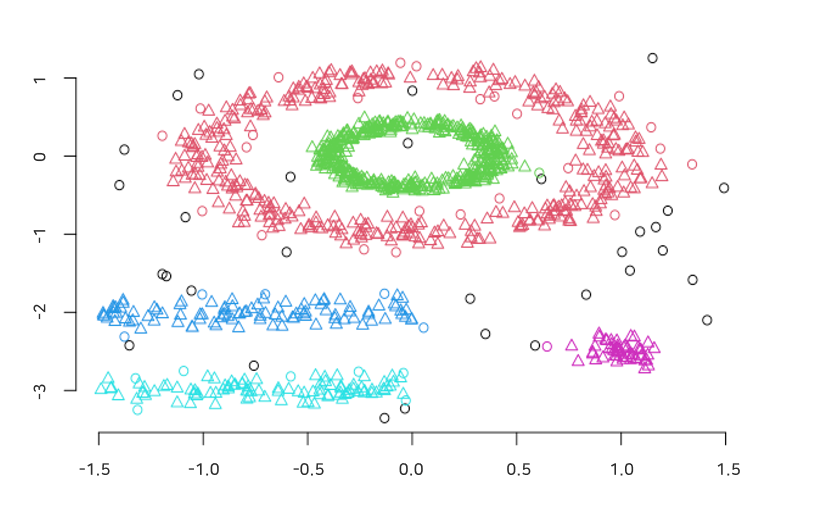

- DBSCAN 클래스 주요 파라미터
    - eps
        - 이웃으로 판단하는 최대 거리(반경)
    - min_samples
        - 이웃 반경 내 최소 샘플 수

In [32]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(0.5, min_samples=5, n_jobs=-1)
cluster.fit(train_ft)

DBSCAN(n_jobs=-1)

In [33]:
np.unique(cluster.labels_) # -1: 노이즈

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22])

In [34]:
silhouette_score(train_ft, cluster.labels_)

0.7371930757396534

## Agglomerative Clustering
- 가까운 군집들을 연결해 나가면서 계층적으로 군집화 하는 기법
- 모든 데이터에 대해서 각각의 독립적인 군집화를 하고 가까운 군집들을 병합하면서 군집 개수를 줄여 나간다.


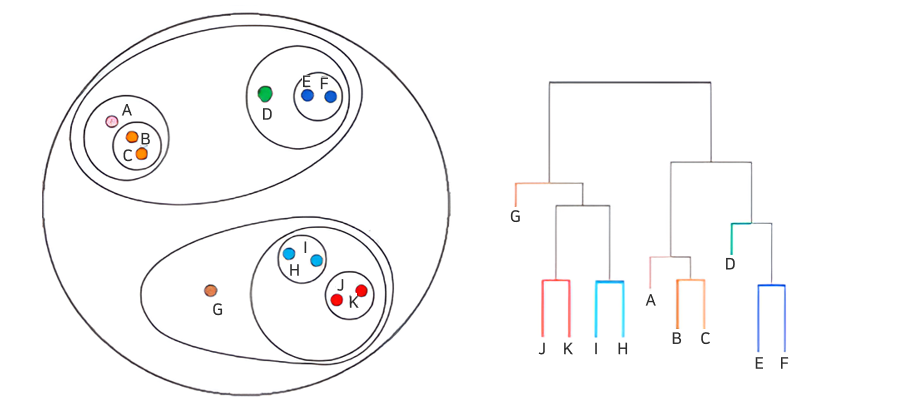

In [35]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(7)
cluster.fit(train_ft)

AgglomerativeClustering(n_clusters=7)

In [36]:
silhouette_score(train_ft, cluster.labels_)

0.40333717029910393

In [140]:
# cluster.predict # 없음

# K 값 찾기

## 실루엣 계수가 높은 K 값 선택(비추천)

In [38]:
for k in range(7, 16):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_ft)
    print(k, silhouette_score(train_ft, cluster.labels_))

7 0.41177112774476704
8 0.4574375986871392
9 0.5050615046570717
10 0.5535966683633855
11 0.6069419223143566
12 0.6443783874703698
13 0.6875817482994422
14 0.6559731433272534
15 0.6684817513508379


## 엘보우(elbow) 방법
- 군집 내 제곱합을 계산하여 K값을 선택하는 방법
- 제곱합(SSE)
    - 데이터 포인트와 해당 군집의 중심점 간의 거리의 제곱합
- K 가 증가할수록 SSE 값은 급격히 감소하다가 어느 순간부터 감소율이 둔화되는데 이 지점의 K 값을 선택하는 방법

In [39]:
import matplotlib.pyplot as plt

sse_list = []
for k in range(2, 20):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_ft)
    sse_list.append(cluster.inertia_) # SSE 값 리스트에 추가

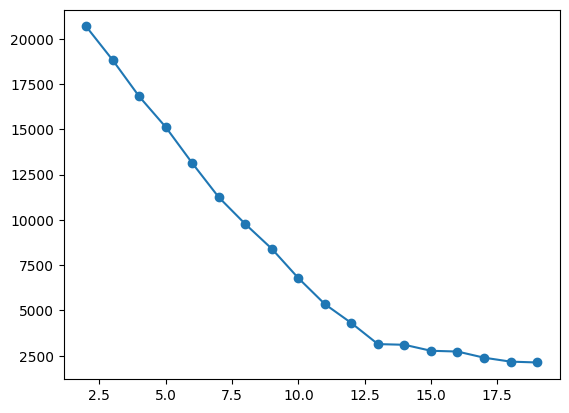

In [40]:
fig, ax = plt.subplots()
ax.plot(range(2, 20), sse_list, marker="o")
plt.show()

## yellowbrick
- 머신러닝 관련 시각화에 특화된 라이브러리
- 사이킷런의 기능과 matplotlib 을 내부적으로 사용

```bash
pip install yellowbrick
```

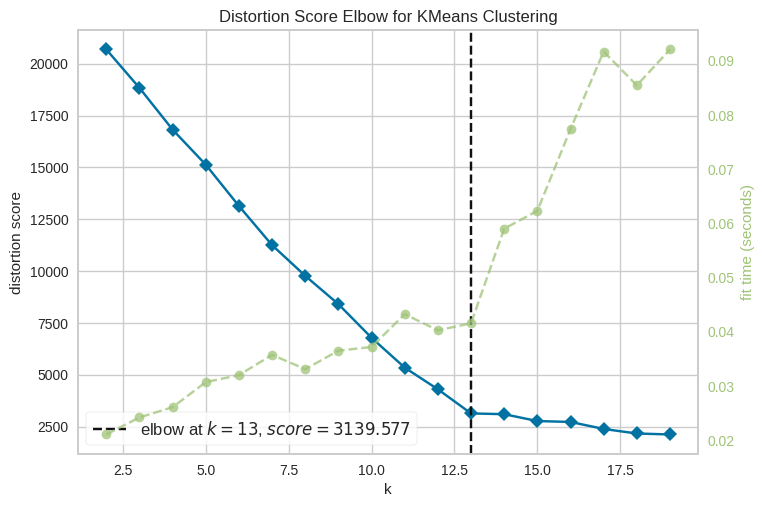

In [41]:
from yellowbrick.cluster import KElbowVisualizer

# 클러스터 객체, k 파라미터에 k 범위 전달
cluster = KMeans(random_state=SEED)
viz = KElbowVisualizer(cluster, k=(2,20))
viz.fit(train_ft)
viz.show()
plt.show()

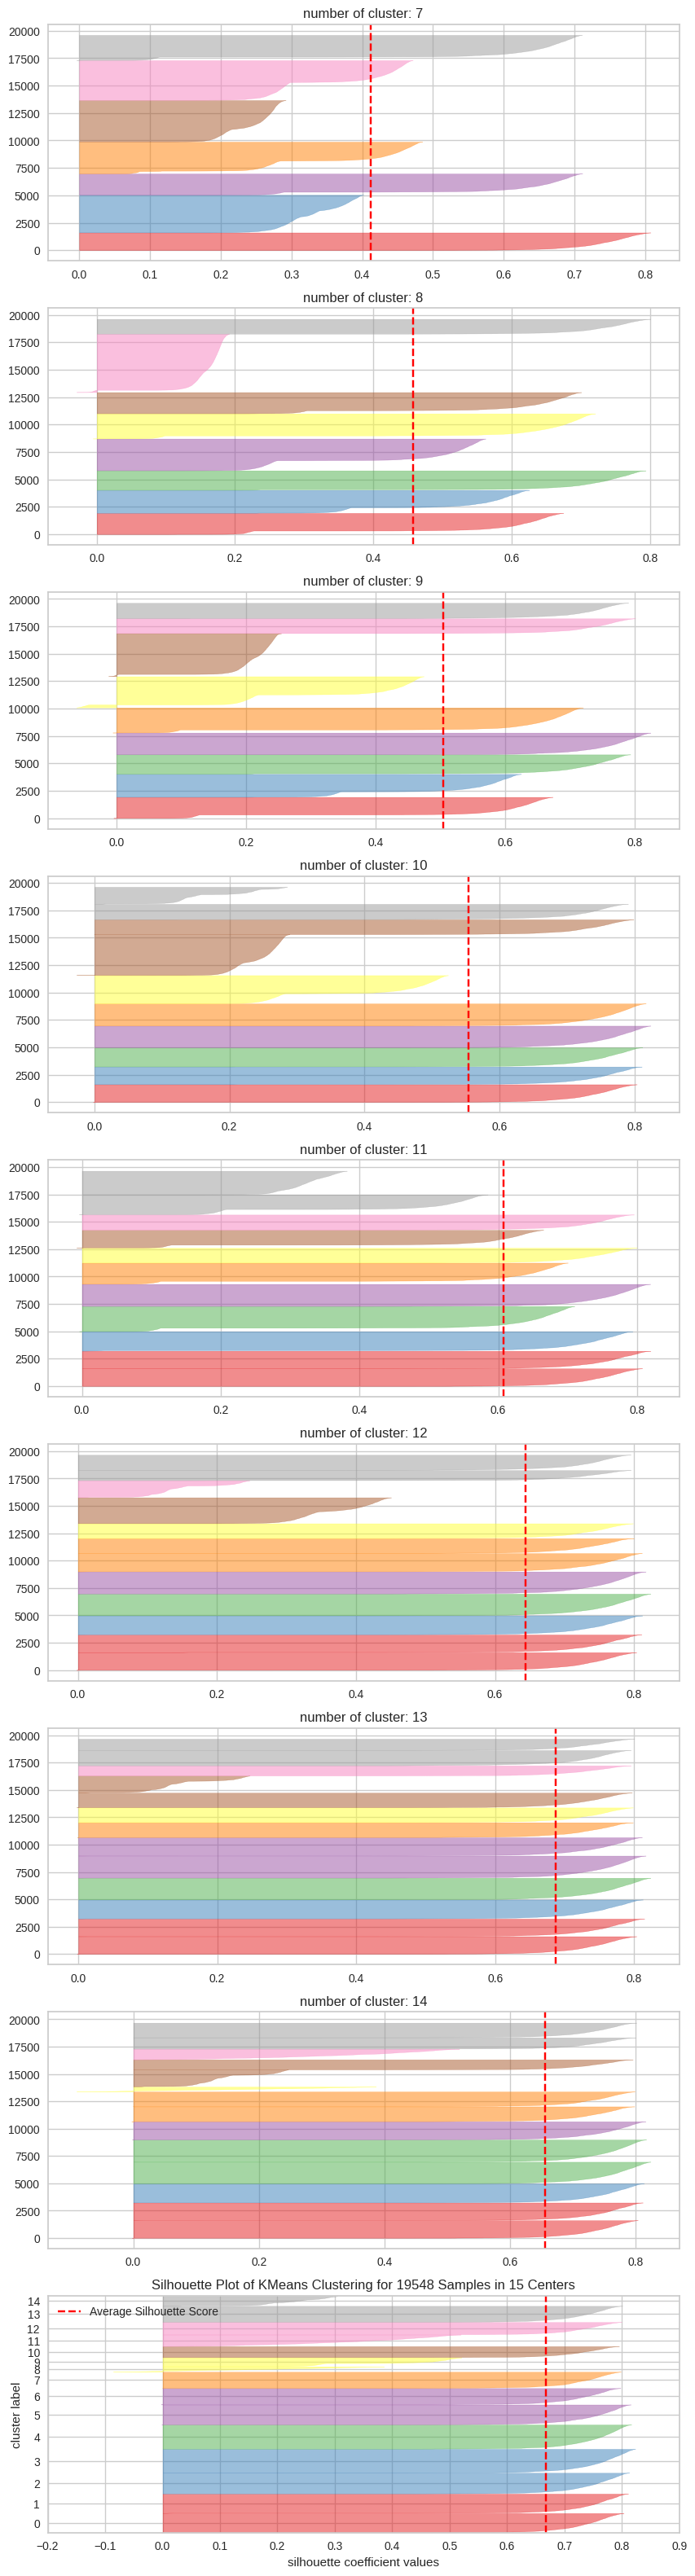

In [43]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(9, figsize=(10, 40))

for i, k in enumerate(range(7, 16)):
    cluster = KMeans(k, random_state=SEED)
    ax[i].set_title(f"number of cluster: {k}")
    viz = SilhouetteVisualizer(cluster, ax=ax[i])
    viz.fit(train_ft)
viz.show()
plt.show()

## 군집분석

In [44]:
cluster = KMeans(13, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=13, random_state=42)

In [45]:
train["cluster"] = cluster.labels_
train.head()

,ID,나이,연간소득,주택소유상태,근로기간,대출목적,대출금액,이자율,신용거래기간,target,cluster
0,train_0,26,33996,임대,10.000000,투자,7000,8.00,2,0,1
1,train_1,34,84000,임대,3.000000,개인사업,9000,5.79,10,0,5
2,train_2,22,24702,임대,4.810613,교육,2000,13.23,4,2,3
3,train_3,24,69996,임대,3.000000,부채통합,2500,12.53,3,1,2
4,train_4,26,58125,모기지론,10.000000,투자,6000,10.25,2,1,8


In [46]:
train["cluster"].value_counts()

,count
cluster,
4,2017
3,1978
2,1733
5,1668
0,1611
1,1601
9,1549
11,1394
6,1356


## 군집별 시각화

In [47]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,460 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123622 files and dire

In [48]:
import seaborn as sns

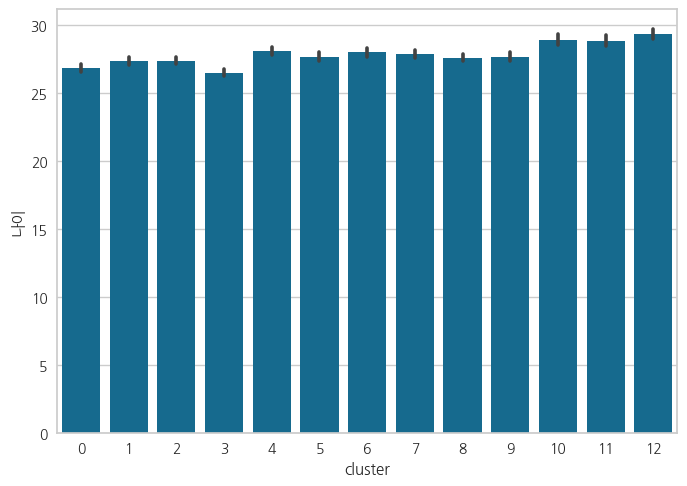

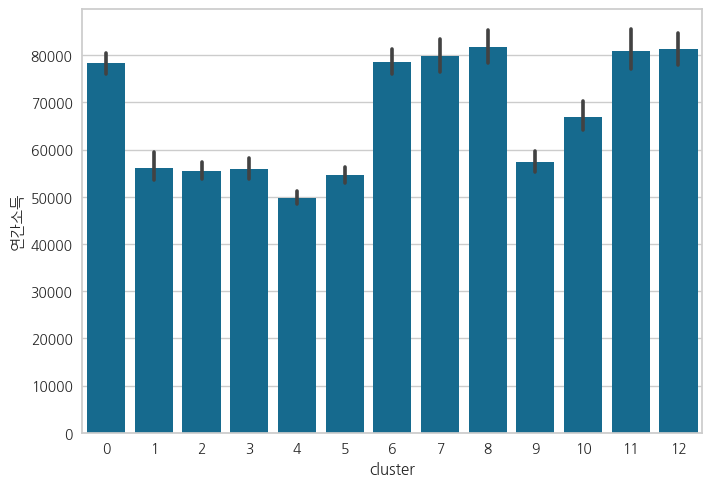

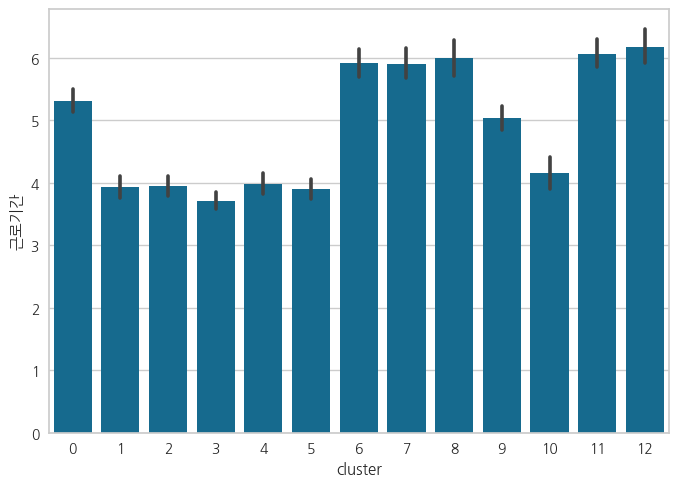

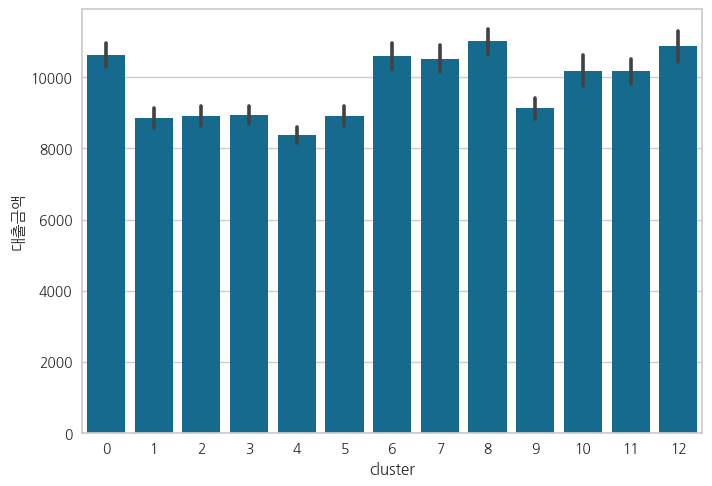

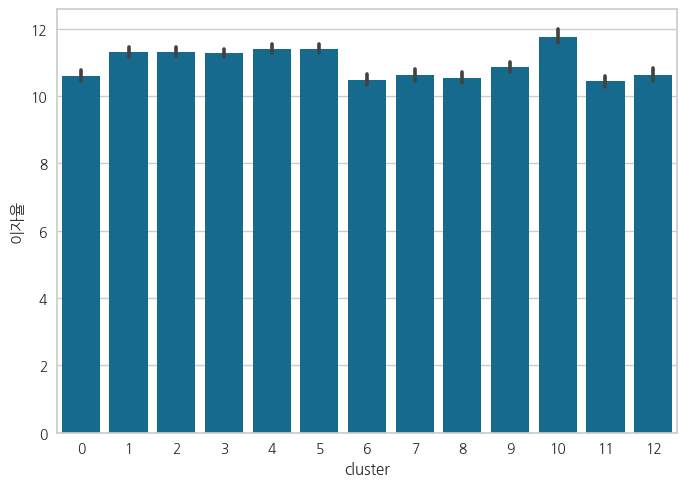

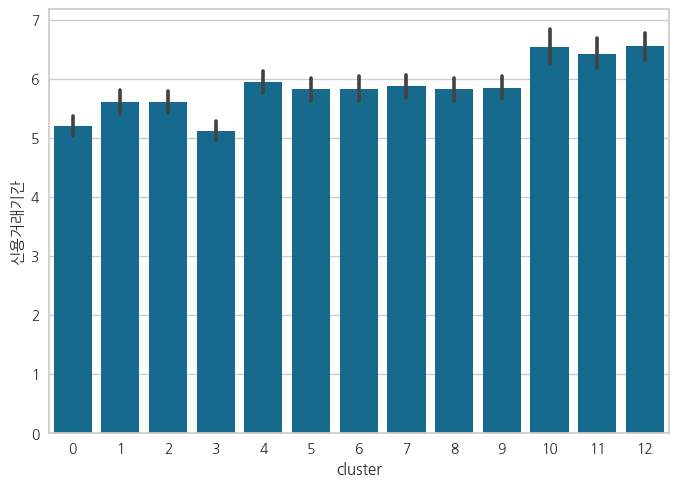

In [49]:
cols_num = ["나이", "연간소득", "근로기간", "대출금액", "이자율", "신용거래기간"]

for col in cols_num:
    sns.barplot(train, x="cluster", y=col)
    plt.show()
    print()

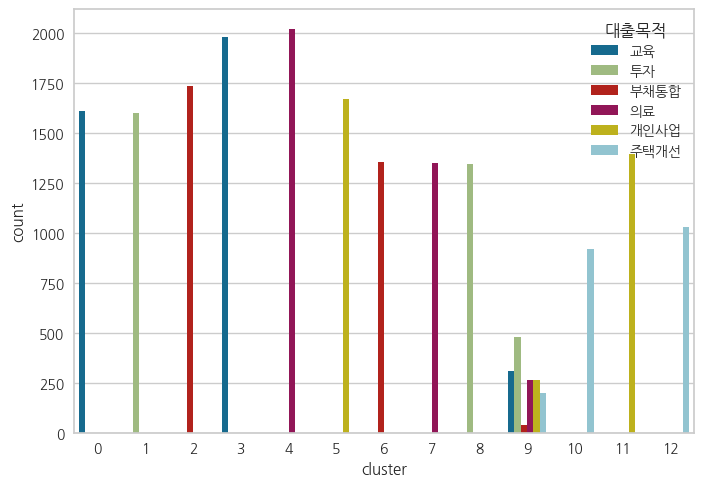

In [51]:
sns.countplot(train, x="cluster", hue="대출목적")
plt.show()

In [52]:
df_cluster = []

for i in range(13):
    mask = train["cluster"] == i
    tmp = train.loc[mask].reset_index(drop=True)
    df_cluster.append(tmp)

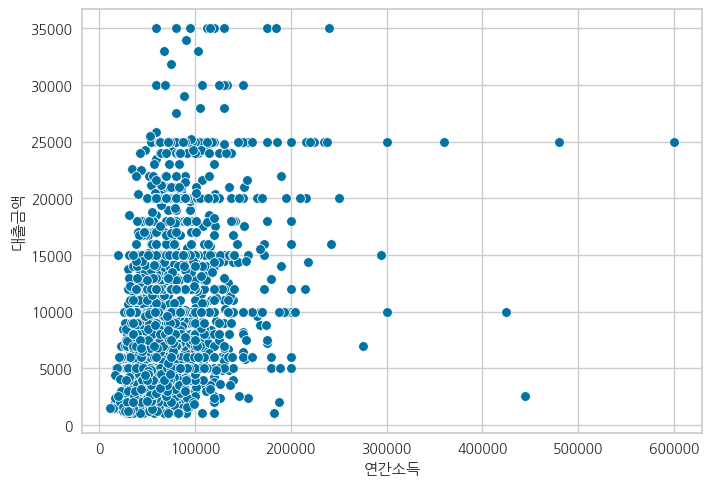

In [53]:
sns.scatterplot(df_cluster[0], x="연간소득", y="대출금액")
plt.show()

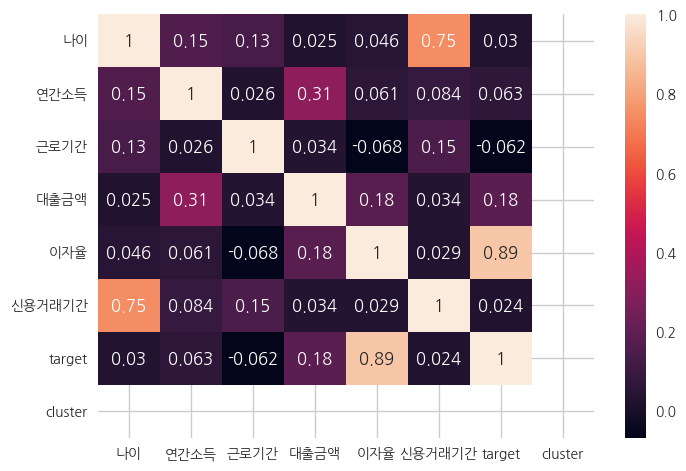

In [54]:
sns.heatmap(df_cluster[0].corr(numeric_only=True), annot=True)
plt.show()

# 군집분석 응용해보기

In [211]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((916, 10), (393, 10), (916,))

In [194]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=SEED)
model.fit(train_ft, target)

[LightGBM] [Info] Number of positive: 346, number of negative: 570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377729 -> initscore=-0.499198
[LightGBM] [Info] Start training from score -0.499198


LGBMClassifier(random_state=42)

In [195]:
pred = model.predict(test_ft)
pred

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,

```
K-means 모델을 이용해서 test 데이터에 대하여 0 또는 1로 예측 수행
```

In [214]:
cluster = KMeans(2, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=2, random_state=42)

In [216]:
target.mean(), cluster.labels_.mean()

(0.3777292576419214, 0.36681222707423583)

In [215]:
pred = cluster.predict(test_ft)
# (pred == 0).astype(int)
pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

In [201]:
pd.DataFrame(pred, columns=["target"]).to_csv("권지혁.csv")